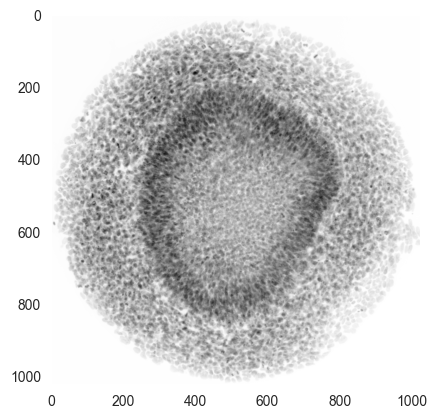

In [51]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt

img = iio.imread("img/neural_crest_pax.lsm")
img = np.sum(img, axis=0)
dapi_img = img[3]
plt.imshow(dapi_img, cmap="gray_r")
plt.grid(False)
plt.show()

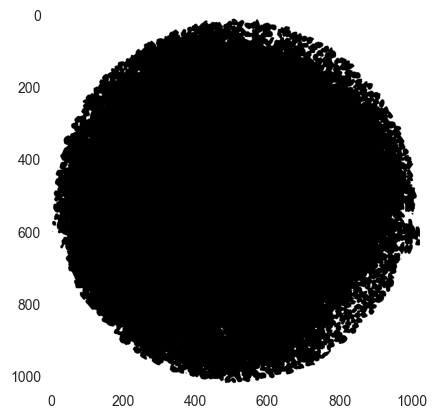

In [53]:
from skimage.filters import threshold_triangle

dapi_img_mask = dapi_img > threshold_triangle(dapi_img)
plt.imshow(dapi_img_mask, cmap="gray_r")
plt.grid(False)
plt.show()

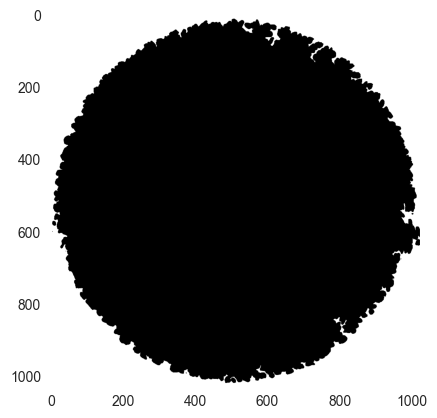

In [54]:
import skimage.morphology as morph

seed = np.copy(dapi_img_mask)
seed[1:-1, 1:-1] = dapi_img_mask.max()
dapi_img_mask = morph.reconstruction(seed, dapi_img_mask, method="erosion")
plt.imshow(dapi_img_mask, cmap="gray_r")
plt.grid(False)
plt.show()

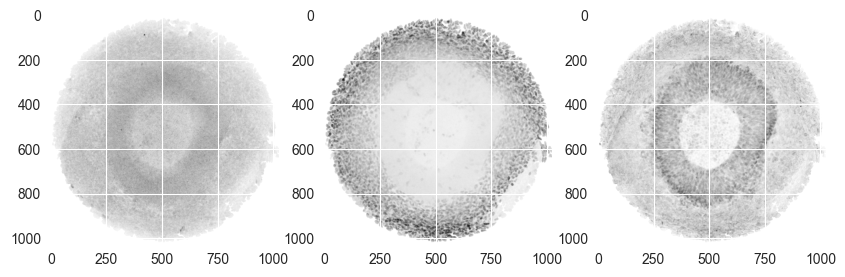

In [56]:
img_chnls = []

(fig, ax) = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    img_chnls.append(dapi_img_mask * img[i])
    ax[i].imshow(img_chnls[i], cmap="gray_r")
img_chnls = np.array(img_chnls)

plt.show()

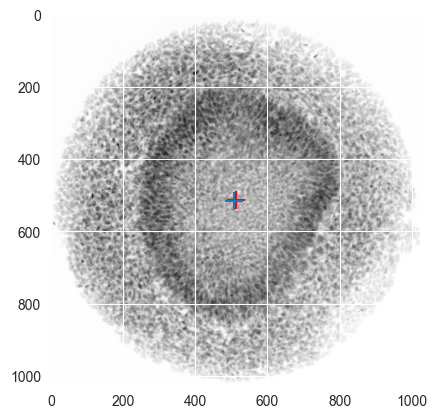

In [63]:
from skimage.measure import regionprops

properties = regionprops(dapi_img_mask.astype(int), dapi_img)
center_of_mass = np.array(properties[0].centroid).astype(int)

fig, ax = plt.subplots()
ax.imshow(dapi_img, cmap="gray_r")
ax.scatter(512, 512, s=160, c='red', marker='+')
ax.scatter(center_of_mass[1], center_of_mass[0], s=160, c='C0', marker='+')
plt.show()

In [65]:
import pandas as pd

cords = np.mgrid[0:dapi_img.shape[0], 0:dapi_img.shape[1]]     # All points in a 3D grid within the given ranges
cords = np.rollaxis(cords, 0, 3)         # Make the 0th axis into the last axis
cords = cords.reshape((dapi_img.shape[0] * dapi_img.shape[1], 2))   # Now you can safely reshape while preserving order
dist = np.linalg.norm(cords - center_of_mass, axis=1).astype(int)

df = pd.DataFrame(np.column_stack((cords, dist, np.transpose(img_chnls.reshape((3, 1024*1024))))))

In [66]:
distance_intensities = df[df.iloc[:, 4] > 0].groupby(2, sort=True).mean()
distance_intensities.reset_index(inplace=True)
distance_intensities

,2,0,1,3,4,5
0,0.0,516.000000,507.000000,1863.000000,880.000000,670.000000
1,1.0,516.000000,507.000000,2477.750000,992.125000,554.625000
2,2.0,516.000000,507.000000,2394.062500,982.625000,603.375000
3,3.0,516.000000,507.000000,2367.800000,968.600000,596.600000
4,4.0,516.000000,507.000000,2304.208333,1010.916667,628.208333
...,...,...,...,...,...,...
526,526.0,632.500000,1020.428571,525.357143,2229.571429,127.214286
527,527.0,633.000000,1021.307692,466.384615,2346.692308,115.692308
528,528.0,633.500000,1022.166667,490.500000,2430.916667,119.500000
529,529.0,636.555556,1022.555556,537.777778,2516.666667,138.333333


In [67]:
from scipy.ndimage import gaussian_filter

img_props = iio.improps("img/pax6_1.tif")
res_x, res_y = 1/np.array(img_props.spacing)

distance_intensities[6] = distance_intensities[2] * res_x
for i in range(3,6):
    sigma = np.nanmean(df[df.iloc[:, 4] > 0].groupby(2, sort=True).std()[i])
    distance_intensities[i+4] = gaussian_filter(distance_intensities[i], 4)

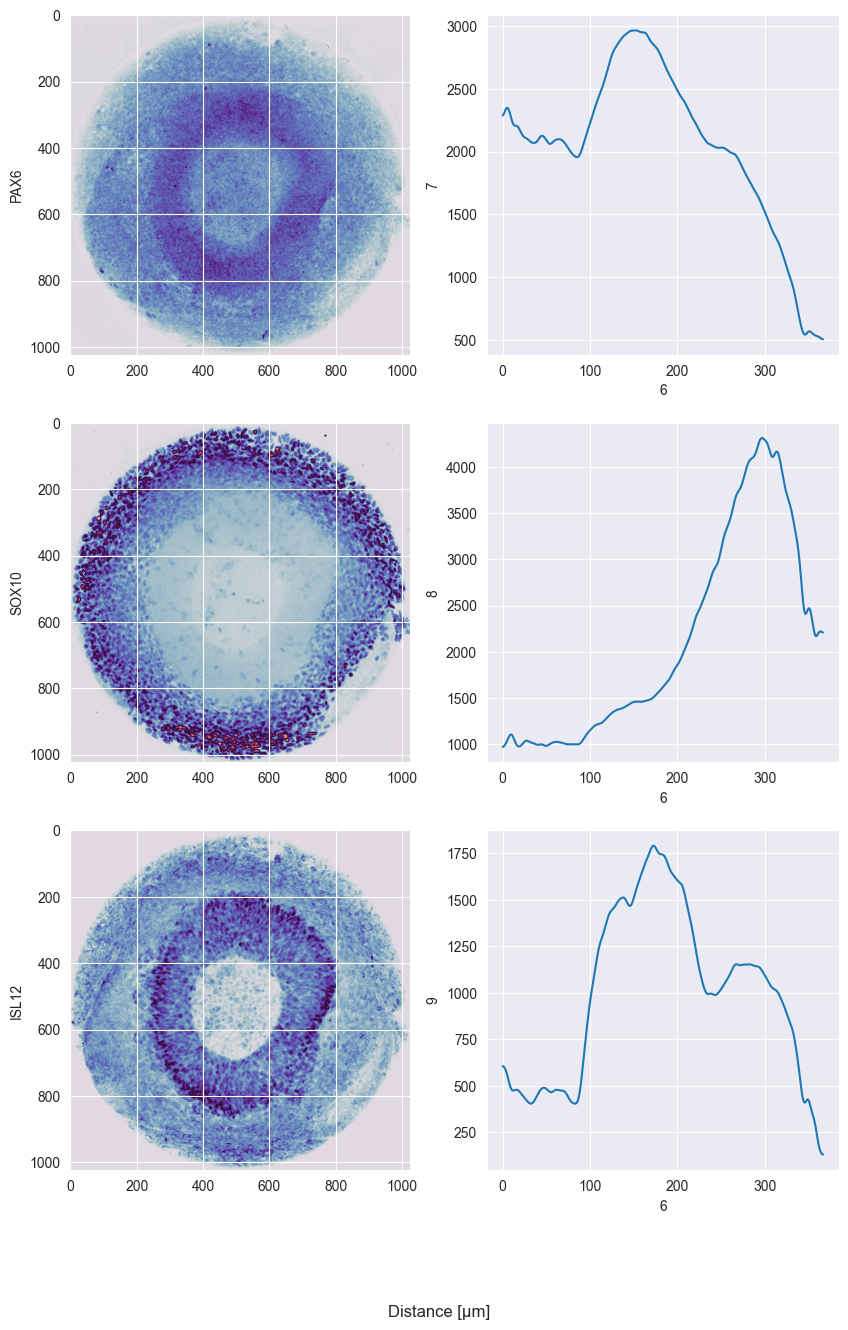

In [68]:
import seaborn as sns

y_labels = ["PAX6", "SOX10", "ISL12"]

(fig, ax) = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    sns.lineplot(distance_intensities, x=6, y=7+i, ax=ax[i][1])
    ax[i][0].imshow(img[i], cmap="twilight")
    ax[i][0].set_ylabel(y_labels[i])
fig.supxlabel("Distance [µm]")
plt.show()

In [123]:
len(ax)

3

In [98]:
"dapi" in [c for c in map(str.lower, iio.immeta("img/neural_crest_pax.lsm").keys())]

False